In [1]:
import torch
import matplotlib.pyplot as plt
import diffstreamlines
from tqdm.auto import tqdm
import numpy as np

# Learn to stay on a specific circle

  0%|          | 0/5000 [00:00<?, ?it/s]

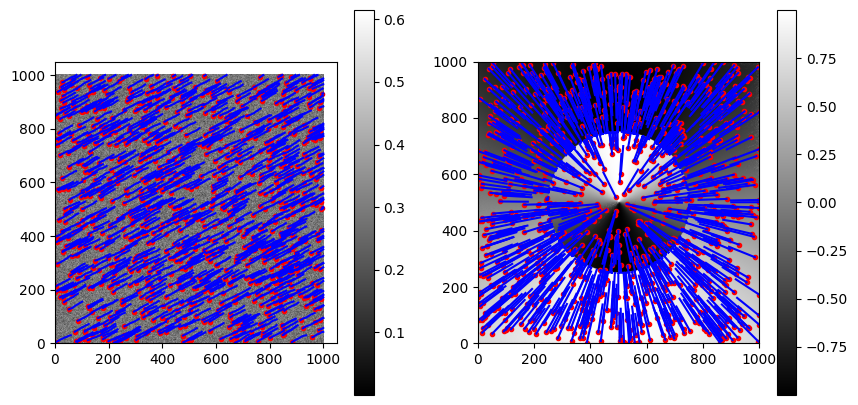

In [2]:
def draw(velocities, initial_points, dt, steps):
    with torch.no_grad():
        paths, path_lengths = diffstreamlines.streamlines(
            velocities, initial_points, dt, steps
        )
        plt.imshow(
            velocities.detach().cpu().numpy()[:, :, 1],
            extent=[0, w, 0, h],
            origin="lower",
            cmap="gray",
        )
        plt.colorbar()
        plt.scatter(
            initial_points[:, 0].cpu().numpy(),
            initial_points[:, 1].cpu().numpy(),
            c="red",
            marker=".",
        )
        for i in range(n):
            l = path_lengths[i].item()
            plt.plot(
                paths[i, :l, 0].detach().cpu().numpy(),
                paths[i, :l, 1].detach().cpu().numpy(),
                color="blue",
            )


def circle_loss(paths, target_r, cx, cy):
    x = paths[:, :, 0]
    y = paths[:, :, 1]
    dist = torch.sqrt((x - cx) ** 2 + (y - cy) ** 2)
    return torch.mean((dist - target_r) ** 2)


def vels(directions, magnitudes):
    sm = torch.sigmoid(magnitudes)
    return torch.stack(
        (
            torch.cos(directions) * sm,
            torch.sin(directions) * sm,
        ),
        dim=-1,
    )


w, h = 1000, 1000
n = 1000
dt = 0.1
steps = 1000
torch.manual_seed(1)
directions = torch.rand(h, w, dtype=torch.float32, device="cuda")
magnitudes = torch.rand(h, w, dtype=torch.float32, device="cuda")
magnitudes.requires_grad_()
directions.requires_grad_()

initial_points = torch.rand((n, 2), dtype=torch.float32, device="cuda")
initial_points[:, 0] *= w
initial_points[:, 1] *= h
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
v = vels(directions, magnitudes)
draw(v, initial_points, dt, steps)
optim = torch.optim.Adam([directions, magnitudes], lr=0.01)
for _ in tqdm(range(5000)):
    optim.zero_grad()
    initial_points = torch.rand((n, 2), dtype=torch.float32, device="cuda")
    initial_points[:, 0] *= w
    initial_points[:, 1] *= h
    paths, path_lengths = diffstreamlines.streamlines(
        vels(directions, magnitudes), initial_points, dt, steps
    )
    loss = circle_loss(paths, w / 4, w / 2, h / 2)
    loss.backward()
    optim.step()
plt.subplot(1, 2, 2)
draw(vels(directions, magnitudes), initial_points, dt, steps)

In [3]:
# use some kind of interactive backend
%matplotlib qt

# Interactive Visualization of the trained velocity field. Click to trace streamline

In [ ]:
v = vels(directions, magnitudes).detach().cpu().numpy() * 0.1
vx = v[:, :, 0]
vy = v[:, :, 1]
v_norm = v - np.min(v)
v_norm /= np.max(v_norm)
im = np.zeros((h, w, 3), dtype=np.float32)
im[:, :, 0] = v_norm[..., 0]
im[:, :, 1] = v_norm[..., 1]
vm = np.sqrt(vx**2 + vy**2)
plt.imshow(im, extent=[0, w, 0, h], origin="lower")
positions = np.stack(
    np.meshgrid(
        np.arange(50, w, 100),
        np.arange(50, h, 100),
    ),
    axis=-1,
)
positions = positions.reshape(-1, 2)
plt.quiver(
    positions[:, 0],
    positions[:, 1],
    v[50::100, 50::100, 0],
    v[50::100, 50::100, 1],
    angles="xy",
    scale_units="xy",
    scale=0.002,
    color="blue",
)
plt.grid()
plt.title("color: ($v_x$,$v_y$,0), arrows: $\\vec{v}$")


def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        x = int(event.xdata)
        y = int(event.ydata)
        with torch.no_grad():
            paths, path_lengths = diffstreamlines.streamlines(
                vels(directions, magnitudes),
                torch.tensor([[x, y]], dtype=torch.float32, device="cuda"),
                dt,
                10000,
            )
        plt.scatter(x, y, color="red", marker=".")
        for i in range(len(path_lengths)):
            l = path_lengths[i].item()
            plt.plot(
                paths[i, :l, 0].detach().cpu().numpy(),
                paths[i, :l, 1].detach().cpu().numpy(),
                color="black",
            )
        plt.draw()


cid = plt.gcf().canvas.mpl_connect("button_press_event", onclick)
plt.show()